<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">Baseline Models with Basic Feature Set</h4>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Baseline Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

[Inspect Training Windows](#Inspect-Training-Windows)

- [Expanding](#Expanding)

- [Rolling](#Rolling)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**

- [1.1. Expanding Window](#1.1.-Expanding-Window)

- [1.2. Rolling Window](#1.2.-Rolling-Window)

**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

- [2.1. Expanding Window](#2.1.-Expanding-Window)

- [2.2. Rolling Window](#2.2.-Rolling-Window)

**[3. Target: Game Winner (moneyline)](#3.-Target:-Game-Winner-(moneyline))**

- [3.1. Expanding Window](#3.1.-Expanding-Window)

- [3.2. Rolling Window](#3.2.-Rolling-Window)

# Setup

[Return to top](#Baseline-Models)

In [1]:
# basic modules
import os
import time
import random as rn
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from functools import reduce

# plotting style
plt.style.use('seaborn-v0_8-notebook')
sns.set_style('white')
#sns.set_style('darkgrid')

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
 
# models
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
  BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor,
  AdaBoostClassifier, GradientBoostingClassifier, StackingRegressor
)
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import StackingClassifier

# metrics & utilities 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import (
  accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score,  
  roc_curve, RocCurveDisplay, auc, average_precision_score, precision_recall_curve, 
  PrecisionRecallDisplay, precision_score, recall_score, f1_score, mean_squared_error
)
from sklearn.utils import resample, class_weight

# variable importance
import shap
from shap.explainers import Tree
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance

# warnings
import warnings
warnings.filterwarnings("ignore")

# user defined functions
import utility_functions as utl

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Baseline-Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [2]:
# load, filter (by time) and scale data
pts_scaled_df, pm_scaled_df, res_scaled_df = utl.load_and_scale_data(
    file_path='../data/processed/nba_team_matchups_rolling_box_scores_2022_2024_r05.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'],
    training_season='2021-22',
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 692 games
Total number of games across sampled seasons: 3059 games


In [3]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181

In [4]:
pts_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,124.0,42.0,87.0,0.483,16.0,38.0,0.421,24.0,31.0,0.774,13.0,33.0,46.0,26.0,18.0,12.0,18.0,22.0,112.0,42.0,87.0,0.483,15.0,29.0,0.517,13.0,16.0,0.813,9.0,33.0,42.0,26.0,7.0,5.0,16.0,20.0,185
2021-10-23,83.0,30.0,97.0,0.309,7.0,34.0,0.206,16.0,22.0,0.727,19.0,35.0,54.0,14.0,10.0,4.0,19.0,21.0,87.0,31.0,93.0,0.333,13.0,43.0,0.302,12.0,13.0,0.923,10.0,40.0,50.0,16.0,7.0,3.0,15.0,21.0,198
2021-10-23,121.0,45.0,93.0,0.484,12.0,35.0,0.343,19.0,22.0,0.864,9.0,40.0,49.0,25.0,5.0,5.0,12.0,22.0,115.0,42.0,86.0,0.488,10.0,32.0,0.313,21.0,28.0,0.750,7.0,40.0,47.0,31.0,8.0,2.0,11.0,22.0,239
2021-10-23,123.0,49.0,98.0,0.500,13.0,30.0,0.433,12.0,18.0,0.667,13.0,30.0,43.0,32.0,8.0,3.0,8.0,22.0,95.0,32.0,84.0,0.381,12.0,42.0,0.286,19.0,29.0,0.655,5.0,33.0,38.0,19.0,6.0,0.0,15.0,26.0,232
2021-10-24,124.0,48.0,95.0,0.505,17.0,38.0,0.447,11.0,14.0,0.786,10.0,44.0,54.0,29.0,12.0,10.0,17.0,18.0,134.0,48.0,117.0,0.410,21.0,57.0,0.368,17.0,23.0,0.739,15.0,41.0,56.0,34.0,13.0,9.0,18.0,24.0,204


In [5]:
pm_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,PLUS_MINUS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,124.0,42.0,87.0,0.483,16.0,38.0,0.421,24.0,31.0,0.774,13.0,33.0,46.0,26.0,18.0,12.0,18.0,22.0,112.0,42.0,87.0,0.483,15.0,29.0,0.517,13.0,16.0,0.813,9.0,33.0,42.0,26.0,7.0,5.0,16.0,20.0,7.0
2021-10-23,83.0,30.0,97.0,0.309,7.0,34.0,0.206,16.0,22.0,0.727,19.0,35.0,54.0,14.0,10.0,4.0,19.0,21.0,87.0,31.0,93.0,0.333,13.0,43.0,0.302,12.0,13.0,0.923,10.0,40.0,50.0,16.0,7.0,3.0,15.0,21.0,-8.0
2021-10-23,121.0,45.0,93.0,0.484,12.0,35.0,0.343,19.0,22.0,0.864,9.0,40.0,49.0,25.0,5.0,5.0,12.0,22.0,115.0,42.0,86.0,0.488,10.0,32.0,0.313,21.0,28.0,0.750,7.0,40.0,47.0,31.0,8.0,2.0,11.0,22.0,29.0
2021-10-23,123.0,49.0,98.0,0.500,13.0,30.0,0.433,12.0,18.0,0.667,13.0,30.0,43.0,32.0,8.0,3.0,8.0,22.0,95.0,32.0,84.0,0.381,12.0,42.0,0.286,19.0,29.0,0.655,5.0,33.0,38.0,19.0,6.0,0.0,15.0,26.0,-10.0
2021-10-24,124.0,48.0,95.0,0.505,17.0,38.0,0.447,11.0,14.0,0.786,10.0,44.0,54.0,29.0,12.0,10.0,17.0,18.0,134.0,48.0,117.0,0.410,21.0,57.0,0.368,17.0,23.0,0.739,15.0,41.0,56.0,34.0,13.0,9.0,18.0,24.0,-10.0


In [6]:
res_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,GAME_RESULT
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,124.0,42.0,87.0,0.483,16.0,38.0,0.421,24.0,31.0,0.774,13.0,33.0,46.0,26.0,18.0,12.0,18.0,22.0,112.0,42.0,87.0,0.483,15.0,29.0,0.517,13.0,16.0,0.813,9.0,33.0,42.0,26.0,7.0,5.0,16.0,20.0,1
2021-10-23,83.0,30.0,97.0,0.309,7.0,34.0,0.206,16.0,22.0,0.727,19.0,35.0,54.0,14.0,10.0,4.0,19.0,21.0,87.0,31.0,93.0,0.333,13.0,43.0,0.302,12.0,13.0,0.923,10.0,40.0,50.0,16.0,7.0,3.0,15.0,21.0,0
2021-10-23,121.0,45.0,93.0,0.484,12.0,35.0,0.343,19.0,22.0,0.864,9.0,40.0,49.0,25.0,5.0,5.0,12.0,22.0,115.0,42.0,86.0,0.488,10.0,32.0,0.313,21.0,28.0,0.750,7.0,40.0,47.0,31.0,8.0,2.0,11.0,22.0,1
2021-10-23,123.0,49.0,98.0,0.500,13.0,30.0,0.433,12.0,18.0,0.667,13.0,30.0,43.0,32.0,8.0,3.0,8.0,22.0,95.0,32.0,84.0,0.381,12.0,42.0,0.286,19.0,29.0,0.655,5.0,33.0,38.0,19.0,6.0,0.0,15.0,26.0,0
2021-10-24,124.0,48.0,95.0,0.505,17.0,38.0,0.447,11.0,14.0,0.786,10.0,44.0,54.0,29.0,12.0,10.0,17.0,18.0,134.0,48.0,117.0,0.410,21.0,57.0,0.368,17.0,23.0,0.739,15.0,41.0,56.0,34.0,13.0,9.0,18.0,24.0,0


# Inspect Training Windows

[Return to top](#Baseline-Models)

## Expanding

[Return to top](#Baseline-Models)

In [7]:
# expanding window configuration
initial_train_size = 10  # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation

counter = 0
max_splits_to_show = 15

# show first few splits
for train_indices, test_indices in utl.expanding_window_ts_split(pts_scaled_df, initial_train_size, test_size=test_size):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9

## Rolling

[Return to top](#Baseline-Models)

In [8]:
# expanding window configuration
train_size = 10 # size of training set window
test_size = 1   # leave-one-out (LOO) cross-validation

counter = 0
max_splits_to_show = 15

for train_index, test_index in utl.rolling_window_ts_split(pts_scaled_df, train_size, test_size):
    print("TRAIN:", train_index, "TEST:", test_index)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [14 15 16 17 18 19 20 21 22 23] TEST: [24]


<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Baseline-Models)

<a name="1.1.-Expanding-Window"></a>
## 1.1. Expanding Window

[Return to top](#Baseline-Models)

In [9]:
# configuration for total points with expanding window

initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
expansion_limit = None    # maximum number of new training observations in expansion
test_size = 1             # leave-one-out (LOO) cross-validation
df = pts_scaled_df        # data set to use
target_col = 'TOTAL_PTS'  # target column name

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    df=df,  
    initial_train_size=initial_train_size,
    expansion_limit=expansion_limit,
    test_size=test_size,           
    target_col=target_col, 
    model=LinearRegression()
)

Total time taken: 3.58 seconds


In [10]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 18.92


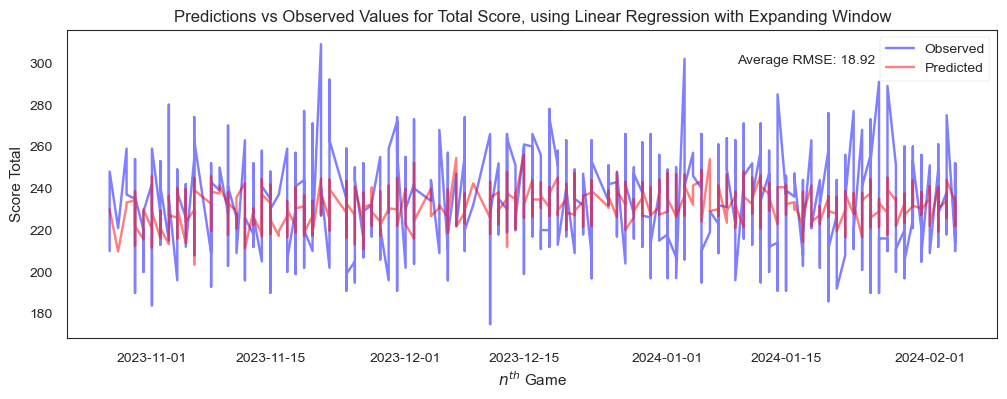

In [11]:
# set end_index based on whether an expansion_limit is specified
if expansion_limit is not None:
    end_index = initial_train_size + expansion_limit * test_size
else:
    # use the length of model_outputs to determine end_index when no limit is specified
    end_index = initial_train_size + len(model_outputs) * test_size

# adjust the observed_values slice accordingly
observed_values = df[target_col][initial_train_size:end_index]
# ensure lengths are the same (for sanity check)
assert len(model_outputs) == len(observed_values), "Length mismatch between predictions and observed values."

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, model_outputs, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Total Score, using Linear Regression with Expanding Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Total')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {metrics['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="1.2.-Rolling-Window"></a>
## 1.2. Rolling Window

[Return to top](#Baseline-Models)

In [12]:
# configuration for total points with rolling window

train_size = 1200         # starting size of the training set
advancement_limit = None  # maximum number of times the training window is advanced
test_size = 1             # leave-one-out (LOO) cross-validation
df = pts_scaled_df        # data set to use
target_col = 'TOTAL_PTS'  # target column name

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    df=df,  
    train_size=train_size, 
    advancement_limit=advancement_limit,
    test_size=test_size,           
    target_col=target_col, 
    model=LinearRegression() 
)

Total time taken: 7.99 seconds


In [13]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 19.21


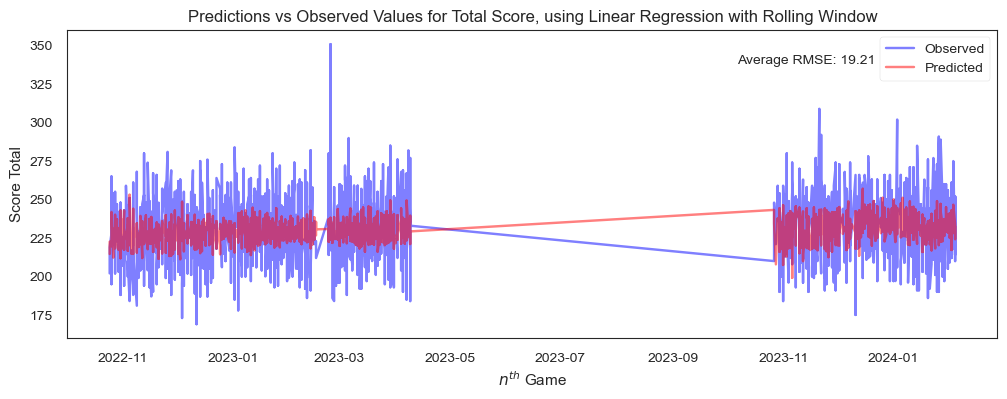

In [14]:
# check if advancement_limit is provided; if not, calculate based on the dataset size
if advancement_limit is not None:
    end_index = train_size + advancement_limit * test_size
else:
    # use the length of model_outputs to determine end_index when no limit is specified
    end_index = train_size + len(model_outputs) * test_size

# given the rolling nature, observed_values should start from the end of the first training set
observed_values = df[target_col][train_size:end_index]
# ensure the lengths of model_outputs and observed_values match
assert len(model_outputs) == len(observed_values), "Length mismatch between predictions and observed values."

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, model_outputs, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Total Score, using Linear Regression with Rolling Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Total')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {metrics['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Baseline-Models)

<a name="2.1.-Expanding-Window"></a>
## 2.1. Expanding Window

[Return to top](#Baseline-Models)

In [16]:
# configuration for points difference with expanding window

initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
expansion_limit = None     # maximum number of new training observations in expansion
test_size = 1              # leave-one-out (LOO) cross-validation
df = pm_scaled_df          # data set to use
target_col = 'PLUS_MINUS'  # target column name

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    df=df,  
    initial_train_size=initial_train_size, 
    expansion_limit=expansion_limit,
    test_size=test_size,           
    target_col=target_col, 
    model=LinearRegression() 
)

Total time taken: 3.61 seconds


In [17]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 14.49


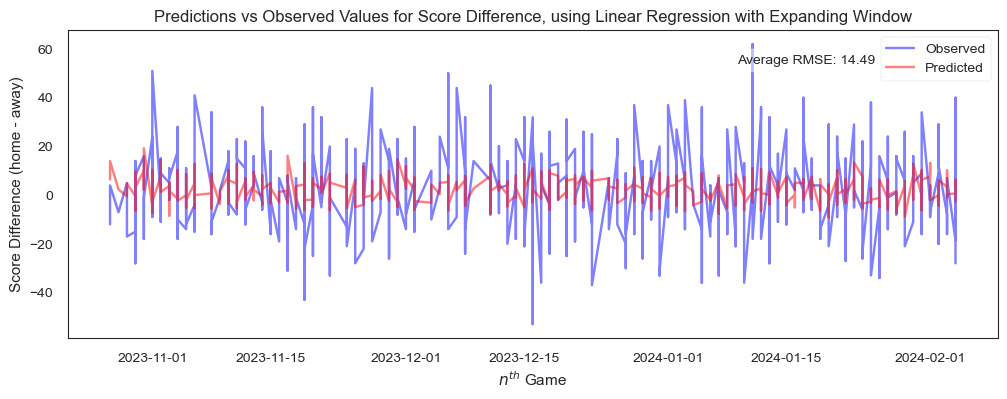

In [18]:
# set end_index based on whether an expansion_limit is specified
if expansion_limit is not None:
    end_index = initial_train_size + expansion_limit * test_size
else:
    # use the length of model_outputs to determine end_index when no limit is specified
    end_index = initial_train_size + len(model_outputs) * test_size

# adjust the observed_values slice accordingly
observed_values = df[target_col][initial_train_size:end_index]
# ensure lengths are the same (for sanity check)
assert len(model_outputs) == len(observed_values), "Length mismatch between predictions and observed values."

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, model_outputs, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Score Difference, using Linear Regression with Expanding Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Difference (home - away)')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {metrics['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="2.2.-Rolling-Window"></a>
## 2.2. Rolling Window

[Return to top](#Baseline-Models)

In [19]:
# configuration for points difference with rolling window

train_size = 1200          # starting size of the training set
advancement_limit = None   # maximum number of times the training window is advanced
test_size = 1              # leave-one-out (LOO) cross-validation
df = pm_scaled_df          # data set to use
target_col = 'PLUS_MINUS'  # target column name

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    df=df,  
    train_size=train_size, 
    advancement_limit=advancement_limit,
    test_size=test_size,           
    target_col=target_col, 
    model=LinearRegression() 
)

Total time taken: 7.96 seconds


In [20]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 13.94


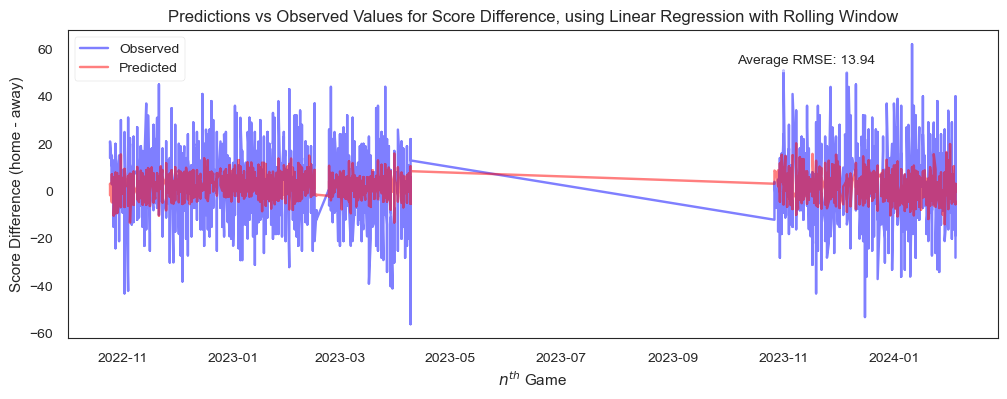

In [21]:
# check if advancement_limit is provided; if not, calculate based on the dataset size
if advancement_limit is not None:
    end_index = train_size + advancement_limit * test_size
else:
    # use the length of model_outputs to determine end_index when no limit is specified
    end_index = train_size + len(model_outputs) * test_size

# given the rolling nature, observed_values should start from the end of the first training set
observed_values = df[target_col][train_size:end_index]
# ensure the lengths of model_outputs and observed_values match
assert len(model_outputs) == len(observed_values), "Length mismatch between predictions and observed values."

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, model_outputs, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Score Difference, using Linear Regression with Rolling Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Difference (home - away)')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {metrics['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="3.-Target:-Game-Winner-(moneyline)"></a>
# 3. Target: Game Winner (moneyline)

[Return to top](#Baseline-Models)

<a name="3.1.-Expanding-Window"></a>
## 3.1. Expanding Window

[Return to top](#Baseline-Models)

In [22]:
# configuration for game winner with expanding window

initial_train_size = season_22_ngames + season_23_ngames  # starting size of the training set
expansion_limit = None      # maximum number of new training observations in expansion
test_size = 1               # leave-one-out (LOO) cross-validation
df = res_scaled_df          # data set to use
target_col = 'GAME_RESULT'  # target column name

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    df=df, 
    initial_train_size=initial_train_size, 
    expansion_limit=expansion_limit,
    test_size=test_size, 
    target_col=target_col, 
    model=LogisticRegression(max_iter=1000, solver='liblinear'),
    ensure_diversity=True # ensure class diversity in training
)  

Total time taken: 7.28 seconds


In [23]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Average Accuracy: 0.64
- Overall AUC: 0.67
- Average F1 Score: 0.70


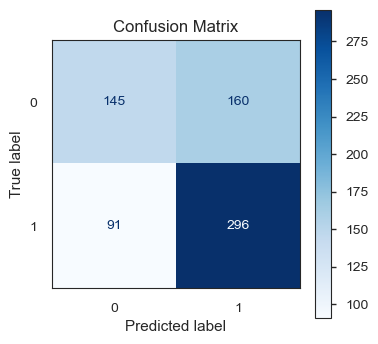

In [24]:
# calculate confusion matrix
cm = confusion_matrix(y_true, metrics['pred_labels'])

# plot
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix');

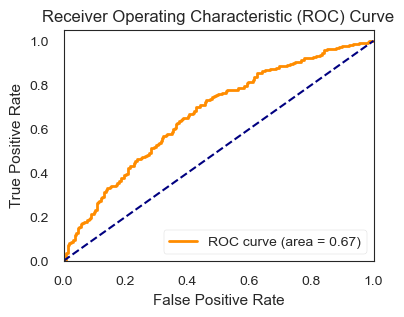

In [25]:
# calculate FPR (False Positive Rate), TPR (True Positive Rate), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, model_outputs)

# calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right");

<a name="3.2.-Rolling-Window"></a>
## 3.2. Rolling Window

[Return to top](#Baseline-Models)

In [26]:
# configuration for game winner with rolling window

train_size = 1200           # starting size of the training set
advancement_limit = None    # maximum number of times the training window is advanced
test_size = 1               # leave-one-out (LOO) cross-validation
df = res_scaled_df          # data set to use
target_col = 'GAME_RESULT'  # target column name

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    df=df,  
    train_size=train_size, 
    advancement_limit=advancement_limit,
    test_size=test_size,           
    target_col=target_col, 
    model=LogisticRegression(max_iter=1000, solver='liblinear'),
    ensure_diversity=True # ensure class diversity in training
)

Total time taken: 13.83 seconds


In [27]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Average Accuracy: 0.59
- Overall AUC: 0.60
- Average F1 Score: 0.68


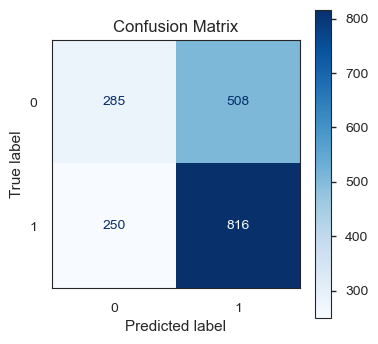

In [28]:
# calculate confusion matrix
cm = confusion_matrix(y_true, metrics['pred_labels'])

# plot
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix');

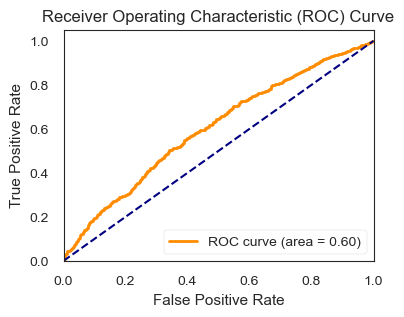

In [29]:
# calculate FPR (False Positive Rate), TPR (True Positive Rate), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, model_outputs)

# calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right");